In [2]:
import requests
import json
import nltk
import string
import math
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from collections import defaultdict, Counter
from locale import normalize
from nltk.corpus import stopwords
from nltk.draw.dispersion import dispersion_plot
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [3]:
#ΒΗΜΑ 1ο ###############################################################################################################

# Συνάρτηση λήψης δεδομένων από κάθε άρθρο τις λίστας
def fetch_articles_from_wiki(title):
    base_url = "https://en.wikipedia.org/wiki/"
    url = base_url + title.replace(" ", "_")
    response = requests.get(url) # Αίτημα HTTP GET στο URL

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser") # Ανάλυση περιεχομένου HTML

        title = soup.find("h1", {"id": "firstHeading"}).text #Εξαγωγή τίτλου και κειμένου
        paragraphs = soup.find_all("p") # Εύρεση όλων των παραγράφων
        content = " ".join([p.text for p in paragraphs]) # Ένωση παραγράφψν σε ένα κείμενο
        return {"title": title, "content": content} # Επιστροφή τίτλου και περιεχομένου
    else:
        print(f"Failed to fetch {title}")
        return None

# Συνάρτηση φόρτωσης και αποθήκευσης δεδομένων από τα άρθρα
def collect_articles(articles, output):
    article_data = []
    for article in articles:
        data = fetch_articles_from_wiki(article) # Κλήση συνάρτησης λήψης δεδομένων από κάθε άρθρο τις λίστας
        if data:
            article_data.append(data) # Προσθήκη κάθε δεδομένου στην λίστα

    # Αποθήκευση δεδομένων σε JSON
    with open(output, "w", encoding="utf-8") as f:
        json.dump(article_data, f, ensure_ascii=False, indent=4) # Αποθήκευση σε JSON
    print("Artciles Saved Successfully!!!")

In [4]:
#ΒΗΜΑ 2ο ###############################################################################################################

# Συνάρτηση επεξεργασίας περιεχομένου κάθε άρθρου
def preprocess_text(text):
    text = text.translate(str.maketrans("", "", string.punctuation)) # Αφαίρεση σημείων στίξης

    tokens = word_tokenize(text.lower()) # Tokenization και μετατροπή σε πεζά γράμματα

    # Αφαίρεση stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Εφαρμογή Stemming
    #stemmer = PorterStemmer()
    #tokens = [stemmer.stem(word) for word in tokens]
    return tokens

# Συνάρτηση φόρτωσης και αποθήκευσης επεξεργασμένων δεδομένων των άρθρων
def preprocess_articles_data(input, output):
    with open(input, "r", encoding="utf-8") as f:
        data = json.load(f) # Φόρτωση δεδομένων από το αρχείο του 1ου Βήματος

    for article in data:
        article["tokens"] = preprocess_text(article["content"]) # Κλήση συνάρτησης επεξεργασίας περιεχομένου κάθε άρθρου

    # Αποθήκευση δεδομένων σε JSON
    with open(output, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4) # Αποθήκευση σε JSON
    print("Preporcessed Articles Data Saved Successully!!!")

In [5]:
#ΒΗΜΑ 3ο ###############################################################################################################

# Συνάρτηση δημιουργίας ανεστραμένου ευρετηρίου
def iverted_index_creation(data):
    inverted_index = defaultdict(list) # Χρήση defaultdict για εύκολη αποθήκευση
    for index, article in enumerate(data):
        for token in set(article["tokens"]): # Χρήση μεθόδου set() για αποφυγή διπλότυπων tokens
            inverted_index[token].append(index) # Αποθήκευση δείκτη κάθε άρθρου για κάθε όρο
    return inverted_index

# Συνάρτηση δημιουργίας ευρετηρίου
def index_creation(input, output):
    with open(input, "r", encoding="utf-8") as f:
        data = json.load(f) # Φόρτωση των προ-επεξεργαμένων δεδομένων από το αρχείο του 2ου Βήματος

    inverted_index = iverted_index_creation(data) # Κλήση συνάρτησης δημιουργίας ανεστραμένου ευρετηρίου

    # Αποθήκευση δεδομένων σε JSON
    with open(output, "w", encoding="utf-8") as f:
        json.dump(inverted_index, f, ensure_ascii=False, indent=4) # Αποθήκευση σε JSON
    print("Inverted Index Saved Successfully!!!")

In [6]:
#ΒΗΜΑ 4ο ###############################################################################################################
# Συνάρτηση εμφάνισης λεξικού διασποράς λέξεων
def plot_dispersion(tokens, preprocessed_articles):
    all_tokens = []
    for article in preprocessed_articles:
        all_tokens.extend(article["tokens"])

    dispersion_plot(all_tokens, tokens)
    plt.title("Dispersion Plot")
    plt.show()

In [7]:
# Συνάρτηση υλοποίησης αλγορίθμου Boolean Search
def boolean_search(query, preprocessed_articles, inverted_index):
    query_tokens = query.lower().split()

    and_terms = []
    or_terms = []
    not_terms = []

    mode = "and"
    for token in query_tokens:
        print(f"Processing token: {token}")
        if token == "and":
            mode = "and"
        elif token == "or":
            mode = "or"
        elif token == "not":
            mode = "not"
        else:
            if mode == "and":
                and_terms.append(token)
            elif mode == "or":
                or_terms.append(token)
            elif mode == "not":
                not_terms.append(token)

    print(f"AND terms: {and_terms}, OR terms: {or_terms}, NOT terms: {not_terms}")

    # Επεξεργασία AND όρων
    and_results = None
    for term in and_terms:
        if term in inverted_index:
            term_docs = set(inverted_index[term])
            print(f"Docs for AND term '{term}': {term_docs}")
            if and_results is None:
                and_results = term_docs
            else:
                and_results &= term_docs

    # Αν δεν υπάρχουν AND όροι, αρχικοποιήστε το σύνολο
    if and_results is None:
        and_results = set(range(len(preprocessed_articles)))  # Όλα τα έγγραφα

    # Επεξεργασία OR όρων
    or_results = set()
    for term in or_terms:
        if term in inverted_index:
            term_docs = set(inverted_index[term])
            print(f"Docs for OR term '{term}': {term_docs}")
            or_results |= term_docs

    # Επεξεργασία NOT όρων
    not_results = set()
    for term in not_terms:
        if term in inverted_index:
            term_docs = set(inverted_index[term])
            print(f"Docs for NOT term '{term}': {term_docs}")
            not_results |= term_docs

    # Συνδυασμός των αποτελεσμάτων
    final_results = and_results  # Ξεκινάμε με τα αποτελέσματα AND
    final_results |= or_results  # Προσθέτουμε τα αποτελέσματα OR
    final_results -= not_results  # Αφαιρούμε τα αποτελέσματα NOT

    # Δημιουργία λίστας αποτελεσμάτων
    return [(preprocessed_articles[doc_id]["title"], preprocessed_articles[doc_id]["content"])for doc_id in sorted(final_results)]


In [8]:
# Συνάρτηση υπολογισμού της IDF (Inverse Document Frequency) για κάθε όρο
def compute_idf(inverted_index, preprocessed_articles):
    idf = {} #Λεξικό IDF για τις τιμές κάθε όρου
    for term, docs in inverted_index.items(): # Διατρέχει όλους τους όρους στο ανεστραμμένο ευρετήριο
        idf[term] = math.log( 1 + (preprocessed_articles / (1 + len(docs))))  # Υπολογίζει την IDF: log(1 + (συνολικά άρθρα / (1 + αριθμός εγγράφων που περιέχουν τον όρο)))
    return idf # Επιστρέφει το λεξικό IDF


In [9]:
# Συνάρτηση υλοποίησης αλγορίθμου TF-IDF
def compute_tfidf(query, preprocessed_articles, inverted_index, idf):
    score = defaultdict(float) # Λεξικό με αρχική τιμή float για την αποθήκευση των TF-IDF σκορ
    query_tokens = preprocess_text(query)  # Μετατροπή ερωτήματος σε tokens

    for term in query_tokens:  # Περιορισμός στους όρους του ερωτήματος
        if term in inverted_index: # Για κάθε όρο στο ανεστραμμένο ευρετήριο
            for doc_id in inverted_index[term]: # Για κάθε άρθρο που περιέχει τον όρο
                tf = preprocessed_articles[doc_id]["tokens"].count(term) # Υπολογίζει τη συχνότητα του όρου
                doc_len = len(preprocessed_articles[doc_id]["tokens"]) # Υπολογίζει το μήκος του άρθρου
                normalized_tf = tf / doc_len # Υπολογίζει το κανονικοποιημένο TF
                score[doc_id] += normalized_tf * idf.get(term, 0) # Προσθέτει το TF-IDF σκορ στο έγγραφο

    ranked_results = sorted(score.items(), key=lambda x: x[1], reverse=True) # Ταξινομεί τα έγγραφα κατά φθίνουσα σειρά TF-IDF σκορ
    return [(preprocessed_articles[doc_id]["title"], preprocessed_articles[doc_id]["content"], score)for doc_id, score in ranked_results]
    # Επιστρέφει μια λίστα από tuples με τον τίτλο, το περιεχόμενο, και το σκορ κάθε άρθρου


In [10]:
# Συνάρτηση υλοποίησης αλγορίθμου Vector Space Model
def vector_space_model(query, preprocessed_articles, inverted_index, idf):
    query_tokens = preprocess_text(query) #Μετατροπή ερωτήματος σε tokens
    query_vector = Counter(query_tokens) # Δημιουργεί ένα διάνυσμα όρων για το ερώτημα
    scores = defaultdict(float) # Λεξικό για τα σκορ των εγγράφων
    doc_vectors = {}  # Αποθηκεύει τα διανύσματα των εγγράφων

    # Δημιουργία διανυσμάτων εγγράφων
    for token in query_tokens: # Για κάθε όρο στο ερώτημα
        if token in inverted_index: # Εάν ο όρος υπάρχει στο ανεστραμμένο ευρετήριο
            for doc_id in inverted_index[token]: # Για κάθε έγγραφο που περιέχει τον όρο
                if doc_id not in doc_vectors:  # Αν δεν έχει δημιουργηθεί ήδη το διάνυσμα
                    tf = preprocessed_articles[doc_id]["tokens"].count(token)
                    #print(f"\nTF:{tf}")
                    #print(f"\nIDF:{idf.get(token, 0)}")
                    scores[doc_id] += tf * idf.get(token, 0) # Προσθήκη στο σκορ του εγγράφου: TF * IDF

    # Υπολογισμός του μεγέθους του διανύσματος του ερωτήματος
    query_magnitude = math.sqrt(sum((tf * idf.get(term, 0)) ** 2 for term, tf in query_vector.items()))
    results = []

    # Υπολογισμός της cosine similarity για κάθε έγγραφο
    for doc_id, score in scores.items():
        # Υπολογισμός μεγέθους διανύσματος του εγγράφου
        doc_magnitude = math.sqrt(sum((tf * idf.get(term, 0)) ** 2 for term in preprocessed_articles[doc_id]["tokens"]))

        # Υπολογισμός cosine similarity
        cosine_similarity = score / (query_magnitude * doc_magnitude) if query_magnitude and doc_magnitude else 0

        results.append((doc_id, cosine_similarity))

    # Ταξινόμηση κατά Cosine Similarity και επιστροφή λίστας με τίτλο, περιεχόμενο, και σκορ για κάθε έγγραφο
    ranked_results = sorted(results, key=lambda x: x[1], reverse=True)
    return [(preprocessed_articles[doc_id]["title"], preprocessed_articles[doc_id]["content"], score) for doc_id, score in ranked_results]


In [11]:
# Συνάρτηση υλοποίησης αλγορίθμου OkapiBM25
def okapiBM25(query, preprocessed_articles, inverted_index, idf, k1=1.5, b=0.75):
    query_tokens = preprocess_text(query)# Επεξεργασία του ερωτήματος για να μετατραπεί σε tokens

    # Υπολογισμός του μέσου μήκους εγγράφου (avg_doc_len)
    avg_doc_len = sum(len(doc["tokens"]) for doc in preprocessed_articles) / len(preprocessed_articles)
    scores = defaultdict(float) # Λεξικό για τα σκορ των εγγράφων

    for token in query_tokens: # Για κάθε όρο στο ερώτημα
        if token in inverted_index: # Εάν ο όρος υπάρχει στο ανεστραμμένο ευρετήριο
            for doc_id in inverted_index[token]:  # Για κάθε έγγραφο που περιέχει τον όρο
                # Υπολογισμός TF (term frequency) για το έγγραφο
                tf = preprocessed_articles[doc_id]["tokens"].count(token)
                doc_len = len(preprocessed_articles[doc_id]["tokens"]) # Υπολογισμός μήκους εγγράφου
                idf_score = idf.get(token, 0) # Υπολογισμός IDF

                # Εφαρμογή της φόρμουλας του OkapiBM25
                numerator = tf * (k1 + 1)
                denominator = tf + k1 * (1 - b + b * (doc_len / avg_doc_len))
                scores[doc_id] += idf_score * (numerator / denominator)

    # Ταξινόμηση κατά Cosine Similarity και επιστροφή λίστας με τίτλο, περιεχόμενο, και σκορ για κάθε έγγραφο
    ranked_results = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [(preprocessed_articles[doc_id]["title"], preprocessed_articles[doc_id]["content"], score) for doc_id, score in ranked_results]


In [12]:
# Συνάρτηση υπολογισμού Ακρίβειας
def compute_precision(retrieved, relevant):
    true_positive = len(set(retrieved) & set(relevant))
    return true_positive / len(retrieved) if retrieved else 0

# Συνάρτηση υπολογισμού Ανάκλησης
def compute_recall(retrieved, relevant):
    true_positive = len(set(retrieved) & set(relevant))
    return true_positive / len(relevant) if relevant else 0

# Συνάρτηση υπολογισμού F1 Score
def compute_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Συνάρτηση υπολογισμού Μέσης Ακρίβειας (MAP)
def compute_map(results, ground_truth):
    average_precisions = []
    for i, retrieved in enumerate(results):
        relevant = ground_truth[i]
        true_positive = 0
        precision_sum = 0
        for j, doc in enumerate(retrieved):
            if doc in relevant:
                true_positive += 1
                precision_sum += true_positive / (j + 1)
        if relevant:
            average_precisions.append(precision_sum / len(relevant))
    return sum(average_precisions) / len(average_precisions) if average_precisions else 0

In [13]:
#MAIN FUNCTION #########################################################################################################
def main():
    nltk.download("punkt")
    nltk.download("stopwords")
    #Λίστα άρθρων
    articles = ["Python (programming language)", "Artificial intelligence", "Machine learning", "Java (programming language)", "SQL",
    "Neural network", "Natural language processing", "Big data", "Data mining", "Cloud computing", "Blockchain", "Django (web framework)",
    "Flask (web framework)", "Deep learning", "Internet of things", "Computer vision", "Robotics", "Cybersecurity"]

    # Κλήση συνάρτησης συλλογής των δεδομένων από τα άρθρα
    collect_articles(articles,"wiki_articles.json")

    #nltk.download("punkt")
    #nltk.download("stopwords")
    # Κλήση συνάρτησης επεξεργασίας δεδομένων των άρθρων
    preprocess_articles_data("wiki_articles.json", "preprocessed_wiki_articles.json")

    # Κλήση συνάρτησης δημιουργίας ευρετηρίου
    index_creation("preprocessed_wiki_articles.json", "inverted_index.json")

    # Φόρτωση επεξεργασμένων άρθρων
    with open("preprocessed_wiki_articles.json", "r", encoding="utf-8") as articles_file:
        preprocessed_articles = json.load(articles_file)

    # Φόρτωση ανεστραμμένου ευρετηρίου
    with open("inverted_index.json", "r", encoding="utf-8") as index_file:
        inverted_index = json.load(index_file)


    print("Welcome to our Search Engine!!!")
    print("Available algorithms: 1. Boolean Retrieval  2. TF-IDF  3. Vector Space Model  4. Okapi BM25")

    # Υπολογισμός IDF
    idf = compute_idf(inverted_index, len(preprocessed_articles))

    while True:
        choice = input("Choose algorithm (1/2/3/4 or 'exit' to quit): ").strip()
        if choice.lower() == "exit":
            print("Exiting search engine!!! Goodbye!!!")
            break

        query = input("Enter your search query: ").strip()
        if not query:
            print("Empty query!!! Try again!!!")
            continue

        if choice == "1":
            results = boolean_search(query, preprocessed_articles, inverted_index)
        elif choice == "2":
            results = compute_tfidf(query, preprocessed_articles, inverted_index, idf)
        elif choice == "3":
            results = vector_space_model(query, preprocessed_articles, inverted_index, idf)
        elif choice == "4":
            results = okapiBM25(query, preprocessed_articles, inverted_index, idf)
        else:
            print("Invalid algorithm choice!!! Try again!!!")
            continue

        query_tokens = preprocess_text(query)
        plot_dispersion(query_tokens, preprocessed_articles)

        if results:
            if choice == "1":
                # Υπολογισμός Bag of Words για το query σε κάθε άρθρο
                query_bow_per_article = {}  # Λεξικό για αποθήκευση του Bag of Words ανά άρθρο

                query_tokens_set = set(query_tokens)  # Μετατροπή του query σε σύνολο για γρήγορο έλεγχο
            
                for title, content in results:
                    for article in preprocessed_articles:
                        if article["title"] == title:
                            # Φιλτράρουμε μόνο τα tokens του query που βρίσκονται στο άρθρο
                            filtered_tokens = [token for token in article["tokens"] if token in query_tokens_set]
                            query_bow_per_article[title] = Counter(filtered_tokens)  # Υπολογισμός Bag of Words για το query
                            break

                print("\nQuery Bag of Words per Article:")
                for title, bow in query_bow_per_article.items():
                    print(f"\nArticle Title: {title}")
                    print(f"Query Bag of Words: {bow}")
            else:
                # Υπολογισμός Bag of Words για το query σε κάθε άρθρο
                query_bow_per_article = {}  # Λεξικό για αποθήκευση του Bag of Words ανά άρθρο

                query_tokens_set = set(query_tokens)  # Μετατροπή του query σε σύνολο για γρήγορο έλεγχο
            
                for title, content, _ in results:
                    for article in preprocessed_articles:
                        if article["title"] == title:
                            # Φιλτράρουμε μόνο τα tokens του query που βρίσκονται στο άρθρο
                            filtered_tokens = [token for token in article["tokens"] if token in query_tokens_set]
                            query_bow_per_article[title] = Counter(filtered_tokens)  # Υπολογισμός Bag of Words για το query
                            break

                print("\nQuery Bag of Words per Article:")
                for title, bow in query_bow_per_article.items():
                    print(f"\nArticle Title: {title}")
                    print(f"Query Bag of Words: {bow}")

            print(f"\nFound {len(results)} result(s):\n")
            for index, result in enumerate(results, 1):
                print(f"{index}. {result[0]}")
                if len(result) >= 3:
                    print(f"   Score: {result[2]:.4f}")
                print(f"   {result[1][:250]}...\n")

            # Ground truth δεδομένα για αξιολόγηση
            ground_truth = {
                "Python (programming language)": ["python", "programming", "language"],
                "Artificial intelligence": ["artificial", "intelligence", "AI", "machine"],
                "Machine learning": ["machine", "learning", "ML"],
                "Java (programming language)": ["java", "programming", "language"],
                "SQL": ["sql", "database", "query", "relational"],
                "Neural network": ["neural", "network", "deep"],
                "Natural language processing": ["natural", "language", "processing", "NLP"],
                "Big data": ["big", "data", "analytics"],
                "Data mining": ["data", "mining", "patterns"],
                "Cloud computing": ["cloud", "computing", "infrastructure"],
                "Blockchain": ["blockchain", "distributed", "ledger"],
                "Django (web framework)": ["django", "web", "framework", "python"],
                "Flask (web framework)": ["flask", "web", "framework", "python"],
                "Deep learning": ["deep", "learning", "neural", "networks"],
                "Internet of things": ["internet", "things", "IoT", "connected"],
                "Computer vision": ["computer", "vision", "images", "recognition"],
                "Robotics": ["robotics", "robots", "automation"],
                "Cybersecurity": ["cybersecurity", "security", "cyber", "protection"]
            }

            # Αξιολόγηση
            retrieved_titles = [result[0] for result in results]
            relevant_titles = [title for title, tokens in ground_truth.items() if any(token in query_tokens for token in tokens)]

            precision = compute_precision(retrieved_titles, relevant_titles)
            recall = compute_recall(retrieved_titles, relevant_titles)
            f1_score = compute_f1_score(precision, recall)

            print("\nEvaluation Metrics:")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-Score: {f1_score:.4f}")

            # MAP (Mean Average Precision)
            map_score = compute_map([retrieved_titles], [relevant_titles])
            print(f"MAP (Mean Average Precision): {map_score:.4f}")

        else:
            print("No results found!!! Try a different query!!!")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mantz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mantz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Artciles Saved Successfully!!!
Preporcessed Articles Data Saved Successully!!!
Inverted Index Saved Successfully!!!
Welcome to our Search Engine!!!
Available algorithms: 1. Boolean Retrieval  2. TF-IDF  3. Vector Space Model  4. Okapi BM25


Choose algorithm (1/2/3/4 or 'exit' to quit):  1
Enter your search query:  Machine AND Learning


Processing token: machine
Processing token: and
Processing token: learning
AND terms: ['machine', 'learning'], OR terms: [], NOT terms: []
Docs for AND term 'machine': {0, 1, 2, 3, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17}
Docs for AND term 'learning': {0, 1, 2, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17}


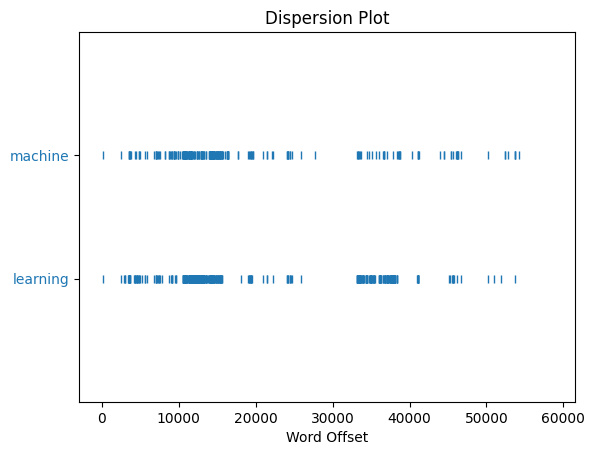


Query Bag of Words per Article:

Article Title: Python (programming language)
Query Bag of Words: Counter({'machine': 2, 'learning': 2})

Article Title: Artificial intelligence
Query Bag of Words: Counter({'learning': 49, 'machine': 40})

Article Title: Machine learning
Query Bag of Words: Counter({'learning': 183, 'machine': 111})

Article Title: Neural network
Query Bag of Words: Counter({'learning': 3, 'machine': 2})

Article Title: Natural language processing
Query Bag of Words: Counter({'machine': 6, 'learning': 6})

Article Title: Big data
Query Bag of Words: Counter({'machine': 5, 'learning': 4})

Article Title: Data mining
Query Bag of Words: Counter({'machine': 8, 'learning': 8})

Article Title: Cloud computing
Query Bag of Words: Counter({'machine': 2, 'learning': 1})

Article Title: Deep learning
Query Bag of Words: Counter({'learning': 117, 'machine': 18})

Article Title: Internet of things
Query Bag of Words: Counter({'machine': 13, 'learning': 8})

Article Title: Compute

Choose algorithm (1/2/3/4 or 'exit' to quit):  exit


Exiting search engine!!! Goodbye!!!


In [14]:
main()